# Thust Wedge Tutorial

Model Setup: Arijit Laik(a.laik@vu.nl)

Revision: Romain Beucher (rbeucher@unimelb.edu.au)

This tutorial is mostly based off Ruh et al. (2013) and other similar stuides, which examine the development thrust sheet and or accretionary wegdes with visco-plastic rheologies .In this 2D model, the boundary conditions, initial conditions,geometry material properties are based on Ruh et al. and other such similar studies.(see Ruh et al. 2013 and references therein: J.B. Ruh, T. Gerya nd J.-P. Burg (2013), G3, v.14(4), p. 1131-1155)

![Tutorial10](./images/Tutorial_10.gif)

In [1]:
import os
import UWGeodynamics as GEO
import numpy as np
import glucifer

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


### Model Scaling

In [2]:
u = GEO.UnitRegistry

velocity = 1 * u.centimeter / u.year
model_length = 100. * u.kilometer
bodyforce = 2700. * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling["[length]"] = KL
GEO.scaling["[time]"] = Kt
GEO.scaling["[mass]"] = KM

In [3]:
Model = GEO.Model(
    elementRes=(256 , 128),
    minCoord=(0. * u.kilometer, -7 * u.kilometer),
    maxCoord=(128. * u.kilometer, 9. * u.kilometer),
    gravity=(0.0, -9.81 * u.meter / u.second**2))

In [4]:
Model.outputDir = "outputs_tutorial10"

### Material Setup

We will start by defining the air layer, the rigid base and the frictional layer.

In [5]:
air_shape = GEO.shapes.Layer(top=Model.top, bottom=0. * u.kilometer)
fricLayerShape = GEO.shapes.Layer(top=Model.bottom + 1. * u.kilometer, bottom=Model.bottom + 0.5 * u.kilometer)
rigidBaseShape = GEO.shapes.Layer(top=Model.bottom + 0.5 * u.kilometer, bottom=Model.bottom)

air = Model.add_material(name="Air", shape=air_shape)
frictionalBasal = Model.add_material(name="Frictional", shape=fricLayerShape)
rigidBase = Model.add_material(name="Frictional", shape=rigidBaseShape)
sediment = Model.add_material(name="Sediment")

### Pile of sedimentary layers

We define a 6km thick pile of sedimentary layers, with each layer being 0.5 km thick, for a total of 12 layers

In [6]:
top_pile = 0.
bottom_pile = -6.0 * u.kilometer 

NLayers = 12
layer_thickness = (top_pile - bottom_pile) / NLayers

plastic_pile = []

layer_above = air_shape

for index in range(NLayers):
    shape = GEO.shapes.Layer(top=layer_above.bottom, bottom=layer_above.bottom - layer_thickness)
    Model.add_material(name="Plastic {0}".format(index), shape=shape)
    plastic_pile.append(shape)
    layer_above = shape


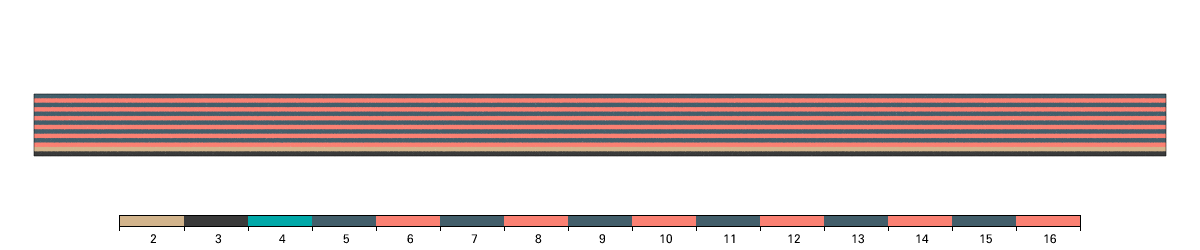

In [7]:
colours = 'tan #3A3A3A #00a8a8 ' + 6 * '#425e6a salmon '

FigMat = glucifer.Figure(figsize=(1200, 250), quality=3)
FigMat.Points(Model.swarm, Model.materialField, 
           discrete=True, 
           colours=colours,
           fn_mask=Model.materialField > air.index)
FigMat.objects[0].colourBar["binlabels"] = True
FigMat.show()

## Model (Global) properties

In [8]:
Model.density = 2700 * u.kilogram / u.metre**3
Model.viscosity = 1e23 * u.pascal * u.second
Model.maxViscosity = 1e23 * u.pascal * u.second
Model.minViscosity = 5e19 * u.pascal * u.second

## Viscosity

In [9]:
air.viscosity = 1e19 * u.pascal * u.second
air.minViscosity = 1e19 * u.pascal * u.second
air.density = 1. * u.kilogram / u.metre**3

# Note that this is not necessary as this does not differ from the
# Model property.
for material in plastic_pile:
    material.density = 2700 * u.kilogram / u.metre**3
    material.viscosity = 1e23 * u.pascal * u.second
    
frictionalBasal.viscosity = 1e23 * u.pascal * u.second
rigidBase.viscosity = 1e23 * u.pascal * u.second

## Plasticity

In [10]:
plastic_Law = GEO.DruckerPrager(
        cohesion=20. * u.megapascal,
        cohesionAfterSoftening=4. * u.megapascal,
        frictionCoefficient=np.tan(np.radians(25.0)),
        frictionAfterSoftening=np.tan(np.radians(20.0)),
        epsilon1=0.01,
        epsilon2=0.06
    )

for material in plastic_pile:
    material.plasticity = plastic_Law

frictionalBasal.plasticity = GEO.DruckerPrager(
    cohesion=0.1 * u.megapascal,
    frictionCoefficient=np.tan(np.radians(12.0)),
    frictionAfterSoftening=np.tan(np.radians(6.0)),
    epsilon1=0.01,
    epsilon2=0.06
)

## Velocity Boundary Conditions
The rigid base has the same velocity(=1cm/year,or velocity of the left wall), the linear gradational velocity is in the low frictional layer, this prevents the rigid bottom sheet from bending at the left edge, moreover as the rigid bottom sheet is analogous to a Mylar(PET) conveyor belt / sheet in sandbox models(Konstantinovskaya and Malavieille, 2011[https://doi.org/10.1016/j.tecto.2011.01.020], or Bose et al 2014[https://doi.org/10.1016/j.jsg.2014.07.004]) 

In [11]:
import underworld.function as fn

tapeL=frictionalBasal
flthick=GEO.nd(tapeL.top-tapeL.bottom)

conditions = [(Model.y <= GEO.nd(rigidBase.top), GEO.nd(-velocity)),
              (Model.y < GEO.nd(tapeL.top),
               GEO.nd(-velocity)*(flthick-(Model.y-GEO.nd(tapeL.bottom)))/flthick),
              (True, GEO.nd(0. * u.centimeter / u.year))]

fn_condition = fn.branching.conditional(conditions)

Model.set_velocityBCs(left=[fn_condition, 0.],
                      right=[-velocity, None],
                      top=[None, None],
                      bottom=[-velocity, 0.])


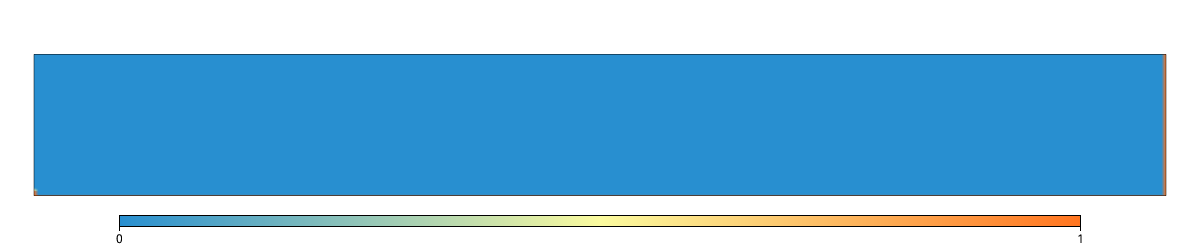

In [12]:
Fig = glucifer.Figure(figsize=(1200, 250), quality=3)
Fig.Surface(Model.mesh, fn.math.dot(Model.velocityField, Model.velocityField))
Fig.show()

In [13]:
GEO.rcParams["solver"] = "mumps"
GEO.rcParams["penalty"] = 1e6
GEO.rcParams["nonlinear.tolerance"] = 1e-3
GEO.rcParams["initial.nonlinear.tolerance"]=1e-5

In [14]:
Model.init_model()

RuntimeError: Error in function of class 'map' constructed at:
0- /workspace/user_data/UWGeodynamics/UWGeodynamics/_model.py:438,
    self._viscosityField.data[:] = self._viscosityFn.evaluate(self.swarm)
0- /workspace/user_data/UWGeodynamics/UWGeodynamics/_model.py:1189,
    rcParams["averaging.method"])
0- /workspace/user_data/UWGeodynamics/UWGeodynamics/_model.py:1883,
    visc = self._getViscousEta()
0- /workspace/user_data/UWGeodynamics/UWGeodynamics/_model.py:1931,
    mapping=ViscosityMap)
0- /opt/underworld2/underworld/timing.py:323,
    return routine(*args, **kwargs)

Error message:
Error evaluating 'map' function.
Key function evaluates to key (3) which
does not appear to map to any functions, and no default function has been set.

In [ ]:
Fig = glucifer.Figure(figsize=(1200, 250), quality=3)
Fig.Points(Model.swarm, GEO.Dimensionalize(Model.viscosityField, u.pascal * u.second), logScale=True)
Fig.show()

In [ ]:
def post_solve_hook():
    global FigMat
    if Model.step % 10 == 0:
        FigMat.save("Material-{0}.png".format(Model.step))
        
Model.postSolveHook = post_solve_hook

In [ ]:
Model.run_for(2.0*u.megayears, checkpoint_interval=0.1 * u.megayear, restartStep=None)

Running with UWGeodynamics version 0.9.8b-dev-29e4c3b(development)
Step:     1 Model Time: 0.01 megayear dt: 0.01 megayear (2018-11-29 02:27:57)
Step:     2 Model Time: 0.01 megayear dt: 0.01 megayear (2018-11-29 02:28:16)
Step:     3 Model Time: 0.02 megayear dt: 0.01 megayear (2018-11-29 02:28:36)
Step:     4 Model Time: 0.02 megayear dt: 0.01 megayear (2018-11-29 02:28:56)
Step:     5 Model Time: 0.03 megayear dt: 0.01 megayear (2018-11-29 02:29:15)
Step:     6 Model Time: 0.04 megayear dt: 0.01 megayear (2018-11-29 02:29:35)
Step:     7 Model Time: 0.04 megayear dt: 0.01 megayear (2018-11-29 02:29:55)
Step:     8 Model Time: 0.05 megayear dt: 0.01 megayear (2018-11-29 02:30:14)
Step:     9 Model Time: 0.06 megayear dt: 0.01 megayear (2018-11-29 02:30:36)
Step:    10 Model Time: 0.06 megayear dt: 0.01 megayear (2018-11-29 02:30:56)
Step:    11 Model Time: 0.07 megayear dt: 0.01 megayear (2018-11-29 02:31:17)
Step:    12 Model Time: 0.07 megayear dt: 0.01 megayear (2018-11-29 02:31:3